In [1]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sn
import time
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

X_train = pd.read_csv("train_features.csv")
y_train = pd.read_csv("train_labels.csv")
X_valid = pd.read_csv("valid_features.csv")
y_valid = pd.read_csv("valid_labels.csv")
X_test = pd.read_csv("test_features.csv")
y_train = y_train["genre"]
y_valid = y_valid["genre"]

Our total number of instances is: 7678
For class metal we have 1143 instances.
For class folk we have 1601 instances.
For class jazz and blues we have 303 instances.
For class soul and reggae we have 930 instances.
For class classic pop and rock we have 1629 instances.
For class punk we have 937 instances.
For class dance and electronica we have 478 instances.
For class pop we have 657 instances.


<BarContainer object of 8 artists>

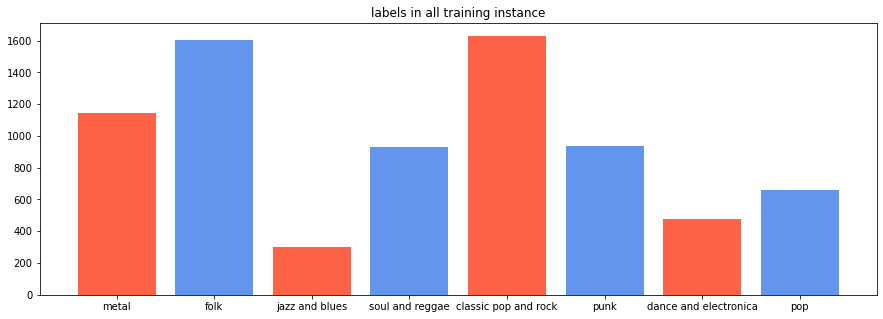

In [2]:
###visualize labels
def count_inst(filestream, class_dict):
    n_instances = 0
    for line in filestream.readlines()[1:]:
        n_instances += 1
        class_dict[line.strip().split(",")[-1]] += 1
    return n_instances

f = open("train_labels.csv",'r')
n_instances = 0
class_dict = defaultdict(int)
class_name = []
class_num = []
print('Our total number of instances is:',count_inst(f,class_dict))

for lbl in class_dict.keys():
    class_name.append(lbl)
    class_num.append(class_dict[lbl])
    print('For class', lbl, 'we have', class_dict[lbl], 'instances.')
plt.figure(1, figsize=(15,5))
plt.title("labels in all training instance")
plt.bar(class_name, class_num, color = ["tomato", "cornflowerblue"])

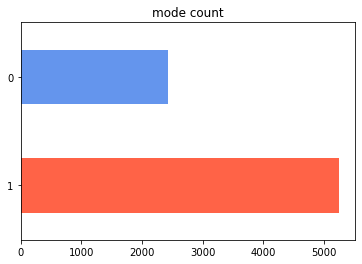

In [3]:
###visulize "mode" feature
X_train["mode"].value_counts().plot(kind='barh',title= "mode count", color = ["tomato", "cornflowerblue"])

In [4]:
###pre-processing
def undersampling (X_train, y_train): # fit with only training data
    rus = RandomUnderSampler(random_state=42, replacement=True)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    return X_train, y_train
def category_1 (X): #select both continuous and discrete data
    X = X.drop(["trackID", "title", "tags"], axis = 1)
    return X
def category_2 (X): #only continuous data
    X =X.drop(["trackID", "title", "tags","time_signature","key","mode"], axis = 1)
    return X

In [5]:
###train function
def train_clf(clf, X_train, y_train):
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print("This model is trained in {:.4f} seconds".format(end-start))

###classifiers
Zero_R_clf = DummyClassifier(strategy='most_frequent')
lgr = LogisticRegression(solver="lbfgs", multi_class="auto",max_iter=10000)
knn = KNeighborsClassifier()

#optimal k for knn classifier
def optimal_k (X_train, y_train, X_valid, y_valid):
    scores = {}
    scores_list = []
    start = time.time()
    for k in range(1,60):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_valid)
        scores[k] = metrics.accuracy_score(y_valid, preds)
        scores_list.append(metrics.accuracy_score(y_valid, preds))
        max_k = max(scores, key=scores.get)
    end = time.time()
    print("optimal k is found in {:.4f} seconds".format(end-start))
    return max_k

In [6]:
###evaluate function
def evaluate_clf(clf, X_train, y_train, X_valid, y_valid):
    train_clf(clf, X_train, y_train)
    print("Accuracy for training set: ", clf.score(X_train, y_train))

    #print('training set confusion matrix:\n',confusion_matrix(y_train,clf.predict(X_train)))
    print('training set report:\n',classification_report(y_train,clf.predict(X_train)))
    print("Accuracy for validation set: ", clf.score(X_valid, y_valid))
    print('validation set confusion matrix:')
    df_valid_cm = pd.DataFrame(confusion_matrix(y_valid,clf.predict(X_valid)))
    sn.set(font_scale=1.4)
    valid_cm = sn.heatmap(df_valid_cm, annot=True, annot_kws={"size":16}, fmt="d", 
                          xticklabels =  ["classic pop and rock","dance and electronica", "folk",
                                          "jazz and blues","metal","pop","punk","sould and raggae"], 
                          yticklabels =  ["classic pop and rock","dance and electronica", "folk",
                                          "jazz and blues","metal","pop","punk","sould and raggae"])

    plt.show(valid_cm)
    #print('validation set confusion matrix:\n',confusion_matrix(y_valid,clf.predict(X_valid)))
    print('validation set report:\n',classification_report(y_valid,clf.predict(X_valid)))

In [7]:
###predict function
def predict_test(clf, X_test):
    start = time.time()
    y_test = clf.predict(X_test)
    end = time.time()
    return y_test

#########Zero-R#########
This model is trained in 0.0030 seconds
Accuracy for training set:  0.21216462620474083
Accuracy for validation set:  0.12222222222222222

#########logistic regression#########
This model is trained in 3.5415 seconds
Accuracy for training set:  0.6462620474081792
training set report:
                        precision    recall  f1-score   support

 classic pop and rock       0.54      0.62      0.58      1629
dance and electronica       0.57      0.41      0.48       478
                 folk       0.64      0.70      0.67      1601
       jazz and blues       0.62      0.38      0.47       303
                metal       0.87      0.90      0.88      1143
                  pop       0.51      0.39      0.44       657
                 punk       0.73      0.74      0.74       937
      soul and reggae       0.61      0.58      0.59       930

             accuracy                           0.65      7678
            macro avg       0.64      0.59      0.61     

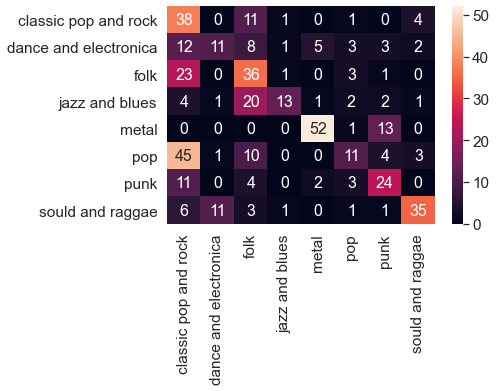

validation set report:
                        precision    recall  f1-score   support

 classic pop and rock       0.27      0.69      0.39        55
dance and electronica       0.46      0.24      0.32        45
                 folk       0.39      0.56      0.46        64
       jazz and blues       0.76      0.30      0.43        44
                metal       0.87      0.79      0.83        66
                  pop       0.44      0.15      0.22        74
                 punk       0.50      0.55      0.52        44
      soul and reggae       0.78      0.60      0.68        58

             accuracy                           0.49       450
            macro avg       0.56      0.48      0.48       450
         weighted avg       0.56      0.49      0.48       450


#########K-Nearest Neighbour#########
optimal k is found in 102.8031 seconds
optimal value for K: 34
This model is trained in 0.3231 seconds
Accuracy for training set:  0.6139619692628289
training set report:
       

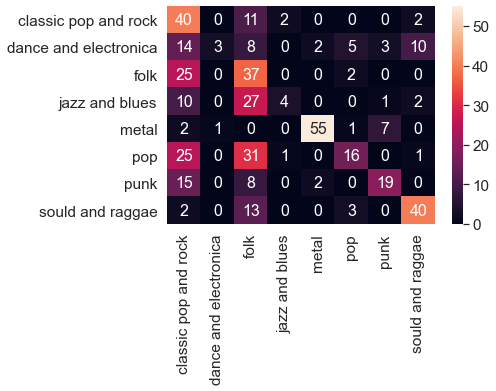

validation set report:
                        precision    recall  f1-score   support

 classic pop and rock       0.30      0.73      0.43        55
dance and electronica       0.75      0.07      0.12        45
                 folk       0.27      0.58      0.37        64
       jazz and blues       0.57      0.09      0.16        44
                metal       0.93      0.83      0.88        66
                  pop       0.59      0.22      0.32        74
                 punk       0.63      0.43      0.51        44
      soul and reggae       0.73      0.69      0.71        58

             accuracy                           0.48       450
            macro avg       0.60      0.45      0.44       450
         weighted avg       0.60      0.48      0.46       450



In [8]:
#(model 1) classify data without sampling using category 1 feature with standization
X_train_full_cate1 = category_1 (X_train)
X_valid_full_cate1 = category_1 (X_valid)
X_test_full_cate1 = category_1 (X_test)
y_train_full_cate1 = y_train
y_valid_full_cate1 = y_valid
scaler = sklearn.preprocessing.StandardScaler(copy=False)
X_train_full_cate1 = scaler.fit_transform(X_train_full_cate1)
X_valid_full_cate1 = scaler.transform(X_valid_full_cate1)
X_test_full_cate1 = scaler.transform(X_test_full_cate1)

print("#########Zero-R#########")
train_clf(Zero_R_clf, X_train_full_cate1, y_train_full_cate1)
print("Accuracy for training set: ", Zero_R_clf.score(X_train_full_cate1, y_train_full_cate1))
print("Accuracy for validation set: ", Zero_R_clf.score(X_valid_full_cate1, y_valid_full_cate1))
y_test_full_cate1_ZeroR = predict_test(Zero_R_clf, X_test_full_cate1)

print("\n#########logistic regression#########")
evaluate_clf(lgr, X_train_full_cate1, y_train_full_cate1, X_valid_full_cate1, y_valid_full_cate1)
y_test_full_cate1_lgr = predict_test(lgr, X_test_full_cate1)

print("\n#########K-Nearest Neighbour#########")
max_k = optimal_k(X_train_full_cate1, y_train_full_cate1, X_valid_full_cate1, y_valid_full_cate1)
knn = KNeighborsClassifier(n_neighbors=max_k)
print("optimal value for K:", max_k)
evaluate_clf(knn, X_train_full_cate1, y_train_full_cate1, X_valid_full_cate1, y_valid_full_cate1)
y_test_full_cate1_knn = predict_test(knn, X_test_full_cate1)

#########Zero-R#########
This model is trained in 0.0000 seconds
Accuracy for training set:  0.125
Accuracy for validation set:  0.12222222222222222

#########logistic regression#########
This model is trained in 1.1340 seconds
Accuracy for training set:  0.6934818481848185
training set report:
                        precision    recall  f1-score   support

 classic pop and rock       0.53      0.52      0.52       303
dance and electronica       0.68      0.69      0.68       303
                 folk       0.68      0.68      0.68       303
       jazz and blues       0.70      0.69      0.70       303
                metal       0.91      0.92      0.91       303
                  pop       0.60      0.59      0.59       303
                 punk       0.78      0.82      0.80       303
      soul and reggae       0.67      0.64      0.66       303

             accuracy                           0.69      2424
            macro avg       0.69      0.69      0.69      2424
        

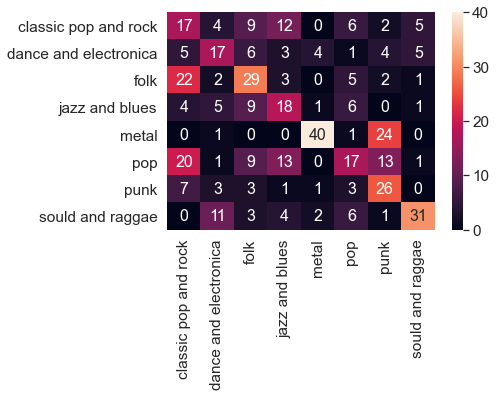

validation set report:
                        precision    recall  f1-score   support

 classic pop and rock       0.23      0.31      0.26        55
dance and electronica       0.39      0.38      0.38        45
                 folk       0.43      0.45      0.44        64
       jazz and blues       0.33      0.41      0.37        44
                metal       0.83      0.61      0.70        66
                  pop       0.38      0.23      0.29        74
                 punk       0.36      0.59      0.45        44
      soul and reggae       0.70      0.53      0.61        58

             accuracy                           0.43       450
            macro avg       0.46      0.44      0.44       450
         weighted avg       0.47      0.43      0.44       450


#########K-Nearest Neighbour#########
optimal k is found in 37.5336 seconds
optimal value for K: 20
This model is trained in 0.0838 seconds
Accuracy for training set:  0.5829207920792079
training set report:
        

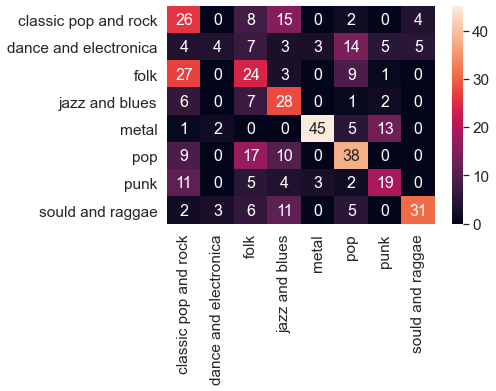

validation set report:
                        precision    recall  f1-score   support

 classic pop and rock       0.30      0.47      0.37        55
dance and electronica       0.44      0.09      0.15        45
                 folk       0.32      0.38      0.35        64
       jazz and blues       0.38      0.64      0.47        44
                metal       0.88      0.68      0.77        66
                  pop       0.50      0.51      0.51        74
                 punk       0.47      0.43      0.45        44
      soul and reggae       0.78      0.53      0.63        58

             accuracy                           0.48       450
            macro avg       0.51      0.47      0.46       450
         weighted avg       0.52      0.48      0.48       450



In [9]:
#(model 2) classify data after sampling using category 1 feature with standization
X_train_sampling_cate1, y_train_sampling_cate1 = undersampling(X_train, y_train)
X_train_sampling_cate1 = category_1 (X_train_sampling_cate1)
X_valid_sampling_cate1 = category_1 (X_valid)
X_test_sampling_cate1 = category_1 (X_test)
y_valid_sampling_cate1 = y_valid
scaler = sklearn.preprocessing.StandardScaler(copy=False)
X_train_sampling_cate1 = scaler.fit_transform(X_train_sampling_cate1)
X_valid_sampling_cate1 = scaler.transform(X_valid_sampling_cate1)
X_test_sampling_cate1 = scaler.transform(X_test_sampling_cate1)

print("#########Zero-R#########")
train_clf(Zero_R_clf, X_train_sampling_cate1, y_train_sampling_cate1)
print("Accuracy for training set: ", Zero_R_clf.score(X_train_sampling_cate1, y_train_sampling_cate1))
print("Accuracy for validation set: ", Zero_R_clf.score(X_valid_sampling_cate1, y_valid_sampling_cate1))
y_test_full_cate1_ZeroR = predict_test(Zero_R_clf, X_test_sampling_cate1)

print("\n#########logistic regression#########")
evaluate_clf(lgr, X_train_sampling_cate1, y_train_sampling_cate1, X_valid_sampling_cate1, y_valid_sampling_cate1)
y_test_sampling_cate1 = predict_test(lgr, X_test_sampling_cate1)

print("\n#########K-Nearest Neighbour#########")

max_k = optimal_k(X_train_sampling_cate1, y_train_sampling_cate1, X_valid_sampling_cate1, y_valid_sampling_cate1)
print("optimal value for K:", max_k)
knn = KNeighborsClassifier(n_neighbors=max_k)
evaluate_clf(knn, X_train_sampling_cate1, y_train_sampling_cate1, X_valid_sampling_cate1, y_valid_sampling_cate1)
y_test_sampling_cate1 = predict_test(knn, X_test_sampling_cate1)


#########Zero-R#########
This model is trained in 0.0030 seconds
Accuracy for training set:  0.21216462620474083
Accuracy for validation set:  0.12222222222222222

#########logistic regression#########
This model is trained in 3.8906 seconds
Accuracy for training set:  0.6411825996353216
training set report:
                        precision    recall  f1-score   support

 classic pop and rock       0.53      0.61      0.56      1629
dance and electronica       0.56      0.41      0.48       478
                 folk       0.63      0.70      0.66      1601
       jazz and blues       0.61      0.36      0.45       303
                metal       0.87      0.90      0.88      1143
                  pop       0.51      0.40      0.45       657
                 punk       0.74      0.75      0.74       937
      soul and reggae       0.61      0.57      0.58       930

             accuracy                           0.64      7678
            macro avg       0.63      0.59      0.60     

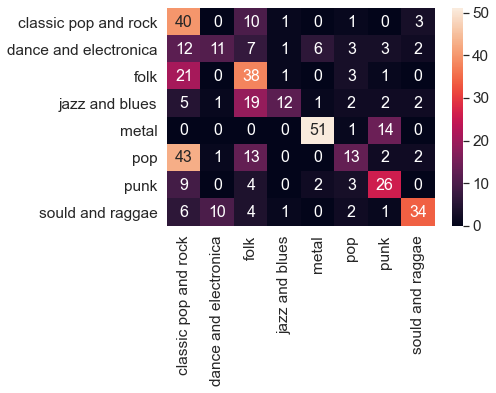

validation set report:
                        precision    recall  f1-score   support

 classic pop and rock       0.29      0.73      0.42        55
dance and electronica       0.48      0.24      0.32        45
                 folk       0.40      0.59      0.48        64
       jazz and blues       0.75      0.27      0.40        44
                metal       0.85      0.77      0.81        66
                  pop       0.46      0.18      0.25        74
                 punk       0.53      0.59      0.56        44
      soul and reggae       0.79      0.59      0.67        58

             accuracy                           0.50       450
            macro avg       0.57      0.50      0.49       450
         weighted avg       0.57      0.50      0.49       450


#########K-Nearest Neighbour#########
optimal k is found in 119.6979 seconds
optimal value for K: 25
This model is trained in 0.3391 seconds
Accuracy for training set:  0.6357124251107059
training set report:
       

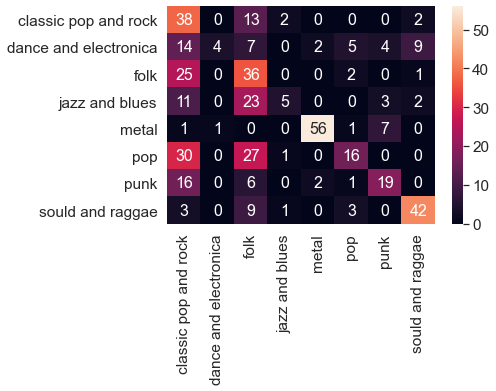

validation set report:
                        precision    recall  f1-score   support

 classic pop and rock       0.28      0.69      0.39        55
dance and electronica       0.80      0.09      0.16        45
                 folk       0.30      0.56      0.39        64
       jazz and blues       0.56      0.11      0.19        44
                metal       0.93      0.85      0.89        66
                  pop       0.57      0.22      0.31        74
                 punk       0.58      0.43      0.49        44
      soul and reggae       0.75      0.72      0.74        58

             accuracy                           0.48       450
            macro avg       0.59      0.46      0.45       450
         weighted avg       0.59      0.48      0.46       450



In [10]:
#(model 3) classify data without sampling using category 2 feature with standization
X_train_full_cate2 = category_2 (X_train)
X_valid_full_cate2 = category_2 (X_valid)
X_test_full_cate2 = category_2 (X_test)
y_train_full_cate2 = y_train
y_valid_full_cate2 = y_valid
scaler = sklearn.preprocessing.StandardScaler(copy=False)
X_train_full_cate2 = scaler.fit_transform(X_train_full_cate2)
X_valid_full_cate2 = scaler.transform(X_valid_full_cate2)
X_test_full_cate2 = scaler.transform(X_test_full_cate2)

print("#########Zero-R#########")
train_clf(Zero_R_clf, X_train_full_cate2, y_train_full_cate2)
print("Accuracy for training set: ", Zero_R_clf.score(X_train_full_cate2, y_train_full_cate2))
print("Accuracy for validation set: ", Zero_R_clf.score(X_valid_full_cate2, y_valid_full_cate2))
y_test_full_cate1_ZeroR = predict_test(Zero_R_clf, X_test_full_cate2)

print("\n#########logistic regression#########")
evaluate_clf(lgr, X_train_full_cate2, y_train_full_cate2, X_valid_full_cate2, y_valid_full_cate2)
y_test_full_cate2_lgr = predict_test(lgr, X_test_full_cate2)

print("\n#########K-Nearest Neighbour#########")
max_k = optimal_k(X_train_full_cate2, y_train_full_cate2, X_valid_full_cate2, y_valid_full_cate2)
knn = KNeighborsClassifier(n_neighbors=max_k)
print("optimal value for K:", max_k)
evaluate_clf(knn, X_train_full_cate2, y_train_full_cate2, X_valid_full_cate2, y_valid_full_cate2)
y_test_full_cate2_knn = predict_test(knn, X_test_full_cate2)

#########Zero-R#########
This model is trained in 0.0010 seconds
Accuracy for training set:  0.125
Accuracy for validation set:  0.12222222222222222

#########logistic regression#########
This model is trained in 1.0302 seconds
Accuracy for training set:  0.6901815181518152
training set report:
                        precision    recall  f1-score   support

 classic pop and rock       0.53      0.53      0.53       303
dance and electronica       0.69      0.69      0.69       303
                 folk       0.66      0.68      0.67       303
       jazz and blues       0.70      0.70      0.70       303
                metal       0.90      0.92      0.91       303
                  pop       0.59      0.58      0.59       303
                 punk       0.77      0.80      0.79       303
      soul and reggae       0.68      0.63      0.65       303

             accuracy                           0.69      2424
            macro avg       0.69      0.69      0.69      2424
        

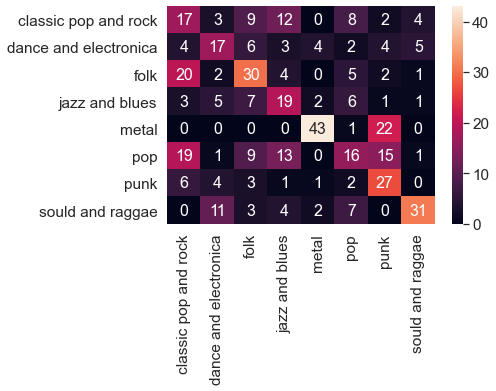

validation set report:
                        precision    recall  f1-score   support

 classic pop and rock       0.25      0.31      0.27        55
dance and electronica       0.40      0.38      0.39        45
                 folk       0.45      0.47      0.46        64
       jazz and blues       0.34      0.43      0.38        44
                metal       0.83      0.65      0.73        66
                  pop       0.34      0.22      0.26        74
                 punk       0.37      0.61      0.46        44
      soul and reggae       0.72      0.53      0.61        58

             accuracy                           0.44       450
            macro avg       0.46      0.45      0.45       450
         weighted avg       0.47      0.44      0.45       450


#########K-Nearest Neighbour#########
optimal k is found in 32.6557 seconds
optimal value for K: 19
This model is trained in 0.0768 seconds
Accuracy for training set:  0.5944719471947195
training set report:
        

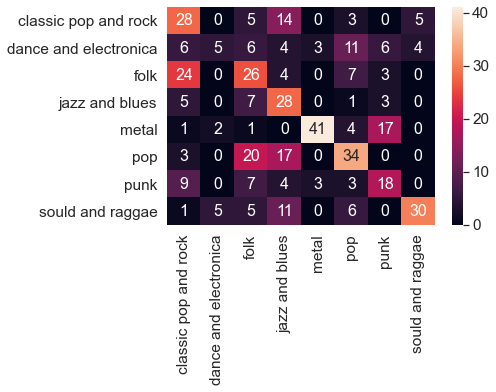

validation set report:
                        precision    recall  f1-score   support

 classic pop and rock       0.36      0.51      0.42        55
dance and electronica       0.42      0.11      0.18        45
                 folk       0.34      0.41      0.37        64
       jazz and blues       0.34      0.64      0.44        44
                metal       0.87      0.62      0.73        66
                  pop       0.49      0.46      0.48        74
                 punk       0.38      0.41      0.40        44
      soul and reggae       0.77      0.52      0.62        58

             accuracy                           0.47       450
            macro avg       0.50      0.46      0.45       450
         weighted avg       0.51      0.47      0.47       450



In [11]:
#(model 4) classify data after sampling using category 2 feature with standization
X_train_sampling_cate2, y_train_sampling_cate2 = undersampling(X_train, y_train)
X_train_sampling_cate2 = category_2 (X_train_sampling_cate2)
X_valid_sampling_cate2 = category_2 (X_valid)
X_test_sampling_cate2 = category_2 (X_test)
y_valid_sampling_cate2 = y_valid
scaler = sklearn.preprocessing.StandardScaler(copy=False)
X_train_sampling_cate2 = scaler.fit_transform(X_train_sampling_cate2)
X_valid_sampling_cate2 = scaler.transform(X_valid_sampling_cate2)
X_test_sampling_cate2 = scaler.transform(X_test_sampling_cate2)

print("#########Zero-R#########")
train_clf(Zero_R_clf, X_train_sampling_cate2, y_train_sampling_cate2)
print("Accuracy for training set: ", Zero_R_clf.score(X_train_sampling_cate2, y_train_sampling_cate2))
print("Accuracy for validation set: ", Zero_R_clf.score(X_valid_sampling_cate2, y_valid_sampling_cate2))
y_test_full_cate1_ZeroR = predict_test(Zero_R_clf, X_test_sampling_cate2)

print("\n#########logistic regression#########")
evaluate_clf(lgr, X_train_sampling_cate2, y_train_sampling_cate2, X_valid_sampling_cate2, y_valid_sampling_cate2)
y_test_sampling_cate2 = predict_test(lgr, X_test_sampling_cate2)
y_test_sampling_cate2_lgr = predict_test(lgr, X_test_sampling_cate2)

print("\n#########K-Nearest Neighbour#########")
max_k = optimal_k(X_train_sampling_cate2, y_train_sampling_cate2, X_valid_sampling_cate2, y_valid_sampling_cate2)
print("optimal value for K:", max_k)
knn = KNeighborsClassifier(n_neighbors=max_k)
evaluate_clf(knn, X_train_sampling_cate2, y_train_sampling_cate2, X_valid_sampling_cate2, y_valid_sampling_cate2)
y_test_sampling_cate2_knn = predict_test(knn, X_test_sampling_cate2)